# Comparación de PHL con otros métodos de selección de instancias

In [122]:
import pandas as pd
import numpy as np
import time
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, accuracy_score

from data_reduction.representativeness import find_epsilon

sys.path.append('../')

import seaborn as sns
import matplotlib.pyplot as plt


dbpath = '../datasets/dry+bean+dataset/DryBeanDataset/Dry_Bean_Dataset.xlsx'
target = 'Class'


SEED = 2025
np.random.seed(SEED)

PROFILING = False # False para tomar todo el dataset, True para tomar una muestra para hacer pruebas rápidas
results_folder = '../results/drybeans/' if not PROFILING else '../results/drybeans_profiling/'

# Check if the results folder exists, if not create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

In [123]:
df = pd.read_excel(dbpath, )

pd.set_option('display.max_columns', None)
print("Tamaño del dataset: ", df.shape)
df.describe()

Tamaño del dataset:  (13611, 17)


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


In [124]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


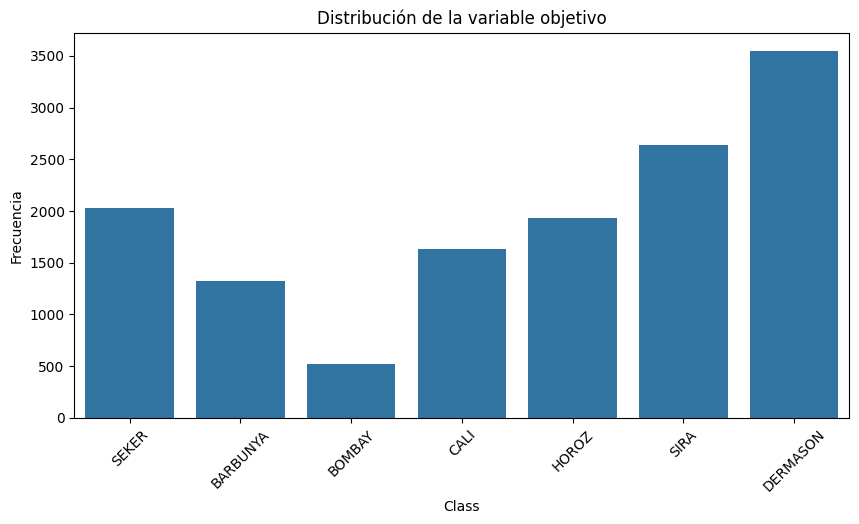

In [125]:
# Show bar plot of the target variable
plt.figure(figsize=(10, 5))
sns.countplot(x=target, data=df)
plt.title('Distribución de la variable objetivo')
plt.xlabel(target)
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()

In [126]:
# Train test split
X = df.drop(columns=[target])
X = np.array(X)

# Convertir la columna target a entero
if not pd.api.types.is_integer_dtype(df[target]):
    le = LabelEncoder()
    y = le.fit_transform(df[target])
else:
    y = df[target].values

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=SEED)

In [127]:
print("Tamaño del conjunto de entrenamiento: ", X_train.shape)
print("Tamaño del conjunto de test: ", X_test.shape)

Tamaño del conjunto de entrenamiento:  (8710, 16)
Tamaño del conjunto de test:  (2723, 16)


In [128]:
# Modelos ML
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
xgb = XGBClassifier(n_estimators=100, random_state=SEED)

## Test de hiperparámetros de PHL

In [129]:
phl_results = pd.read_csv(results_folder + '/phl_results.csv')
srs_results = pd.read_csv(results_folder + '/srs_results.csv')
baseline_results = pd.read_csv(results_folder + '/baseline_results.csv')    
baseline_results

,model,accuracy,f1,training_time
0,KNN,0.918274,0.918330,0.000856
1,RF,0.918733,0.918522,2.602299
2,XGB,0.925620,0.925688,0.490303


In [130]:
phl_results

,model,reduction_method,mode,dimensions,max_dimension,percentage,k,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,PHL,representative,restrictedDim,0,0.05,1,0.049943,14.135125,0.885216,0.886329,0.000476,0.896250
1,RF,PHL,representative,restrictedDim,0,0.05,1,0.049943,14.135125,0.882002,0.882701,0.118748,0.896250
2,XGB,PHL,representative,restrictedDim,0,0.05,1,0.049943,14.135125,0.878329,0.879177,0.108886,0.896250
3,KNN,PHL,representative,restrictedDim,0,0.10,1,0.100000,14.135125,0.892562,0.893110,0.000489,0.896271
4,RF,PHL,representative,restrictedDim,0,0.10,1,0.100000,14.135125,0.906336,0.906567,0.183158,0.896271
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,RF,PHL,vital,multiDim,2,0.75,5,0.749943,13.727648,0.914601,0.914308,1.691983,17.671697
752,XGB,PHL,vital,multiDim,2,0.75,5,0.749943,13.727648,0.921028,0.920746,0.392687,17.671697
753,KNN,PHL,vital,multiDim,2,0.90,5,0.900115,12.627460,0.921947,0.921943,0.000772,17.671838
754,RF,PHL,vital,multiDim,2,0.90,5,0.900115,12.627460,0.918733,0.918492,2.157459,17.671838


In [131]:
# Print hyperparameter grid
print("Hyperparameter grid for PHL selection:")
hyperparameter_columns = [
    'model', 'reduction_method', 'mode', 'k', 'percentage'
]
for column in hyperparameter_columns:
        print(f"{column}: {phl_results[column].unique()}")

print("Dimensions: ", phl_results[['dimensions', 'max_dimension']].drop_duplicates().values)

Hyperparameter grid for PHL selection:
model: ['KNN' 'RF' 'XGB']
reduction_method: ['PHL']
mode: ['representative' 'vital']
k: [ 1  2  3  5  7 10 15]
percentage: [0.05 0.1  0.2  0.3  0.5  0.75 0.9 ]
Dimensions:  [['restrictedDim' 0]
 ['restrictedDim' 1]
 ['multiDim' 2]]


In [132]:
arr = np.array([0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1])
np.where(arr == 1)[0].shape[0]

5

In [133]:
# Get row with maximum accuracy for each model, perc, mode, dimensions and max_dimension
def get_best_row(df, model, perc):
    filtered_df = df[
        (df['model'] == model) &
        (df['percentage'] == perc)]
    if not filtered_df.empty:
        return filtered_df.loc[filtered_df['accuracy'].idxmax()]
    return None

# Show df with best metrics
def show_best_metrics(df):
    best_df = pd.DataFrame()
    for model in df['model'].unique():
        for perc in df['percentage'].unique():
            best_row = get_best_row(df, model, perc)
            if best_row is not None:
                best_df = best_df.append(best_row, ignore_index=True)
    return best_df

best_df = show_best_metrics(phl_results)
best_df

# Reorder columns
best_df = best_df[['model', 'percentage', 'mode', 'dimensions', 'max_dimension', 'k', 'accuracy', 'f1', 'training_time', 'reduction_time']]
best_df

,model,percentage,mode,dimensions,max_dimension,k,accuracy,f1,training_time,reduction_time
0,KNN,0.05,representative,restrictedDim,1.0,1.0,0.902663,0.902626,0.000457,1.051823
1,KNN,0.10,representative,restrictedDim,1.0,3.0,0.903581,0.903618,0.000480,1.725190
2,KNN,0.20,vital,restrictedDim,0.0,1.0,0.913223,0.912822,0.000518,0.896416
3,KNN,0.30,representative,restrictedDim,1.0,1.0,0.911846,0.912117,0.000548,1.052130
4,KNN,0.50,vital,restrictedDim,1.0,1.0,0.914601,0.914803,0.000620,1.052451
5,KNN,0.75,representative,restrictedDim,1.0,2.0,0.926538,0.926487,0.000697,1.418646
6,KNN,0.90,vital,multiDim,2.0,5.0,0.921947,0.921943,0.000772,17.671838
7,RF,0.05,representative,restrictedDim,1.0,2.0,0.899449,0.898754,0.121855,1.417699
8,RF,0.10,vital,multiDim,2.0,1.0,0.908173,0.908018,0.185451,1.141966
9,RF,0.20,representative,restrictedDim,1.0,1.0,0.912764,0.912918,0.368881,1.052003


In [134]:
best_df[best_df['mode'] == 'representative']

,model,percentage,mode,dimensions,max_dimension,k,accuracy,f1,training_time,reduction_time
0,KNN,0.05,representative,restrictedDim,1.0,1.0,0.902663,0.902626,0.000457,1.051823
1,KNN,0.10,representative,restrictedDim,1.0,3.0,0.903581,0.903618,0.000480,1.725190
3,KNN,0.30,representative,restrictedDim,1.0,1.0,0.911846,0.912117,0.000548,1.052130
5,KNN,0.75,representative,restrictedDim,1.0,2.0,0.926538,0.926487,0.000697,1.418646
7,RF,0.05,representative,restrictedDim,1.0,2.0,0.899449,0.898754,0.121855,1.417699
9,RF,0.20,representative,restrictedDim,1.0,1.0,0.912764,0.912918,0.368881,1.052003
10,RF,0.30,representative,restrictedDim,0.0,2.0,0.914141,0.914190,0.532834,1.089761
14,XGB,0.05,representative,restrictedDim,1.0,1.0,0.910468,0.909989,0.138051,1.051823
16,XGB,0.20,representative,restrictedDim,1.0,1.0,0.913682,0.914117,0.203989,1.052003
17,XGB,0.30,representative,multiDim,2.0,2.0,0.915519,0.915322,0.235359,2.570927


In [135]:
best_df[best_df['mode'] == 'vital']

,model,percentage,mode,dimensions,max_dimension,k,accuracy,f1,training_time,reduction_time
2,KNN,0.20,vital,restrictedDim,0.0,1.0,0.913223,0.912822,0.000518,0.896416
4,KNN,0.50,vital,restrictedDim,1.0,1.0,0.914601,0.914803,0.000620,1.052451
6,KNN,0.90,vital,multiDim,2.0,5.0,0.921947,0.921943,0.000772,17.671838
8,RF,0.10,vital,multiDim,2.0,1.0,0.908173,0.908018,0.185451,1.141966
11,RF,0.50,vital,restrictedDim,1.0,1.0,0.917815,0.917966,1.105561,1.052451
12,RF,0.75,vital,multiDim,2.0,1.0,0.922406,0.922435,1.736371,1.142820
13,RF,0.90,vital,restrictedDim,0.0,1.0,0.922406,0.922308,2.231913,0.897359
15,XGB,0.10,vital,multiDim,2.0,1.0,0.911846,0.911840,0.142142,1.141966
19,XGB,0.75,vital,multiDim,2.0,1.0,0.929752,0.929834,0.416724,1.142820
20,XGB,0.90,vital,restrictedDim,0.0,2.0,0.929752,0.929728,0.454597,1.090657


In [136]:
srs_results

,model,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,0.05,0.049598,12.326925,0.897245,0.897385,0.000372,0.003036
1,KNN,0.10,0.099656,12.773578,0.907989,0.908012,0.000375,0.002985
2,KNN,0.20,0.199656,11.985204,0.909826,0.909845,0.000415,0.003051
3,KNN,0.30,0.299770,9.781288,0.913499,0.913511,0.000452,0.003088
4,KNN,0.50,0.499885,9.598834,0.914784,0.914764,0.000522,0.003170
5,KNN,0.75,0.749713,5.394263,0.917447,0.917482,0.000605,0.003265
6,KNN,0.90,0.899770,3.571090,0.917906,0.917946,0.000655,0.003301
7,RF,0.05,0.049598,12.326925,0.902020,0.901742,0.126222,0.003036
8,RF,0.10,0.099656,12.773578,0.912856,0.912747,0.206132,0.002985
9,RF,0.20,0.199656,11.985204,0.911570,0.911447,0.397101,0.003051


In [145]:
srs_results

,model,percentage,reduction_ratio,representativeness,accuracy,f1,training_time,reduction_time
0,KNN,0.05,0.049598,12.326925,0.897245,0.897385,0.000372,0.003036
1,KNN,0.10,0.099656,12.773578,0.907989,0.908012,0.000375,0.002985
2,KNN,0.20,0.199656,11.985204,0.909826,0.909845,0.000415,0.003051
3,KNN,0.30,0.299770,9.781288,0.913499,0.913511,0.000452,0.003088
4,KNN,0.50,0.499885,9.598834,0.914784,0.914764,0.000522,0.003170
5,KNN,0.75,0.749713,5.394263,0.917447,0.917482,0.000605,0.003265
6,KNN,0.90,0.899770,3.571090,0.917906,0.917946,0.000655,0.003301
7,RF,0.05,0.049598,12.326925,0.902020,0.901742,0.126222,0.003036
8,RF,0.10,0.099656,12.773578,0.912856,0.912747,0.206132,0.002985
9,RF,0.20,0.199656,11.985204,0.911570,0.911447,0.397101,0.003051


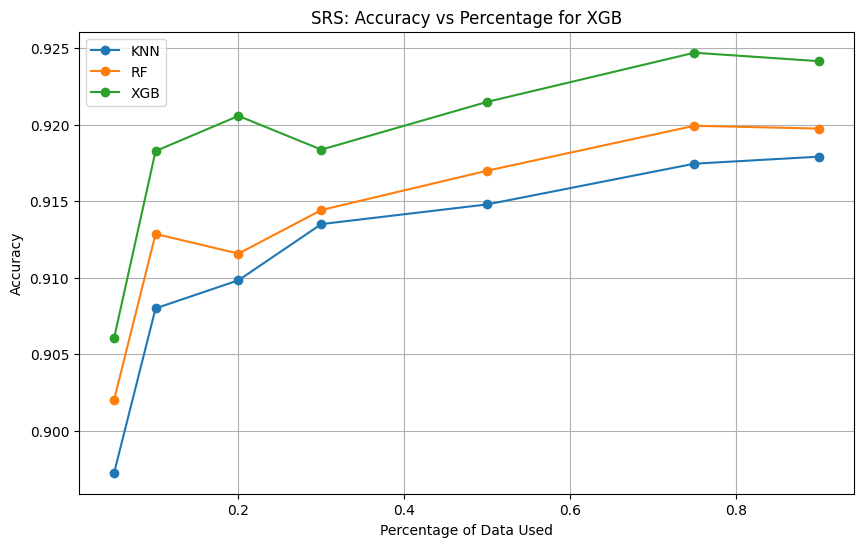

In [147]:
# Show accuracy vs percentage for SRS
plt.figure(figsize=(10, 6))
for model in srs_results['model'].unique():
    model_results = srs_results[srs_results['model'] == model]
    plt.plot(model_results['percentage'], model_results['accuracy'], marker='o', label=model)
plt.title(f'SRS: Accuracy vs Percentage for {model}')
plt.xlabel('Percentage of Data Used')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()

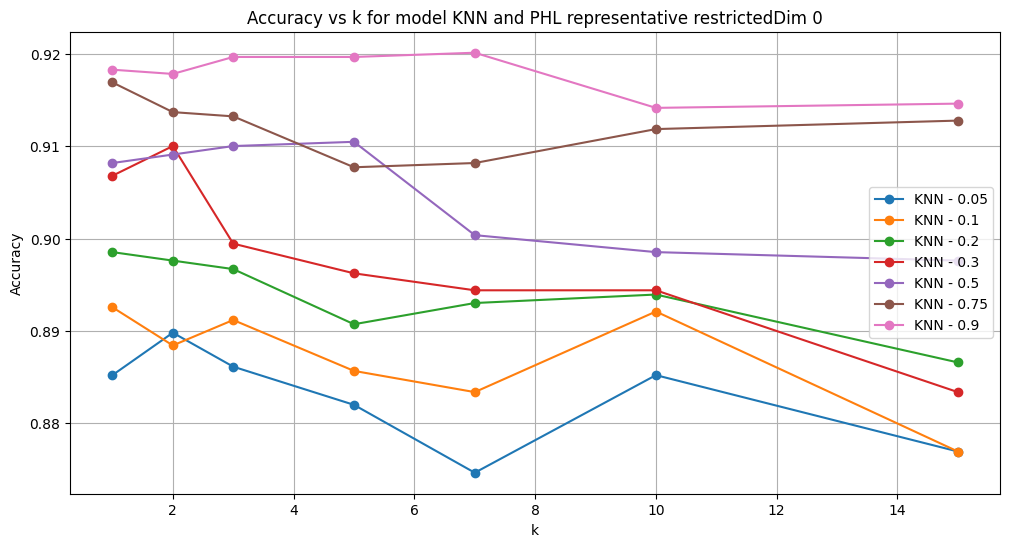

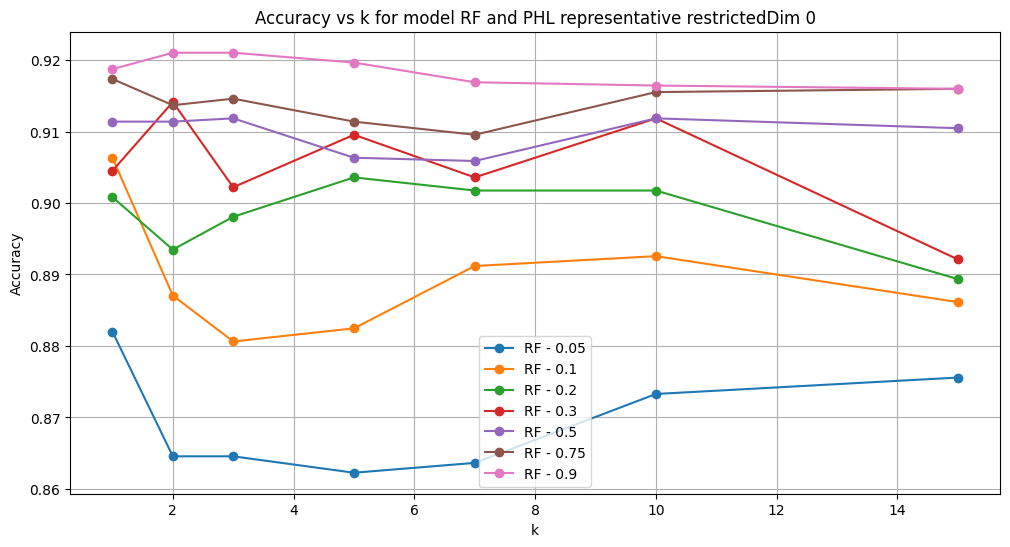

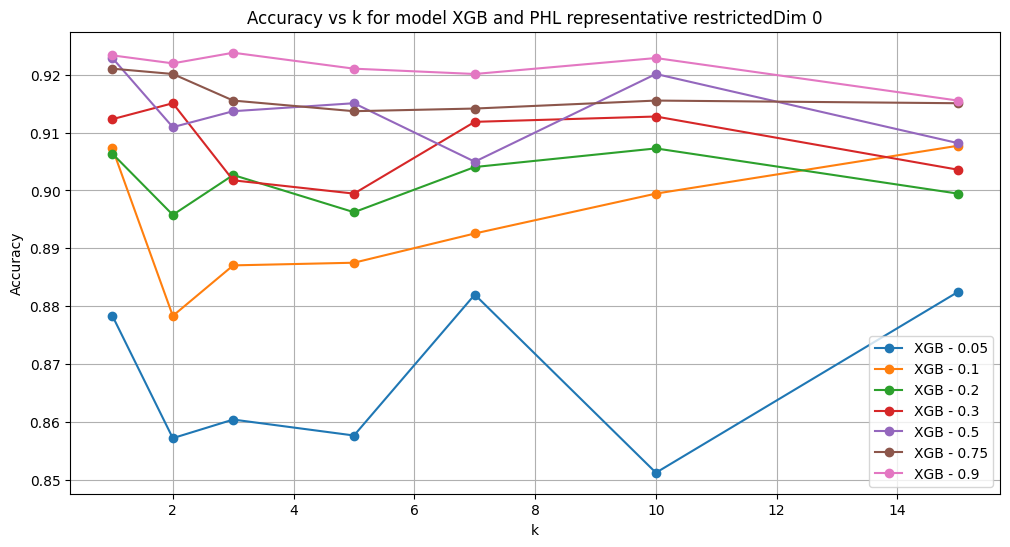

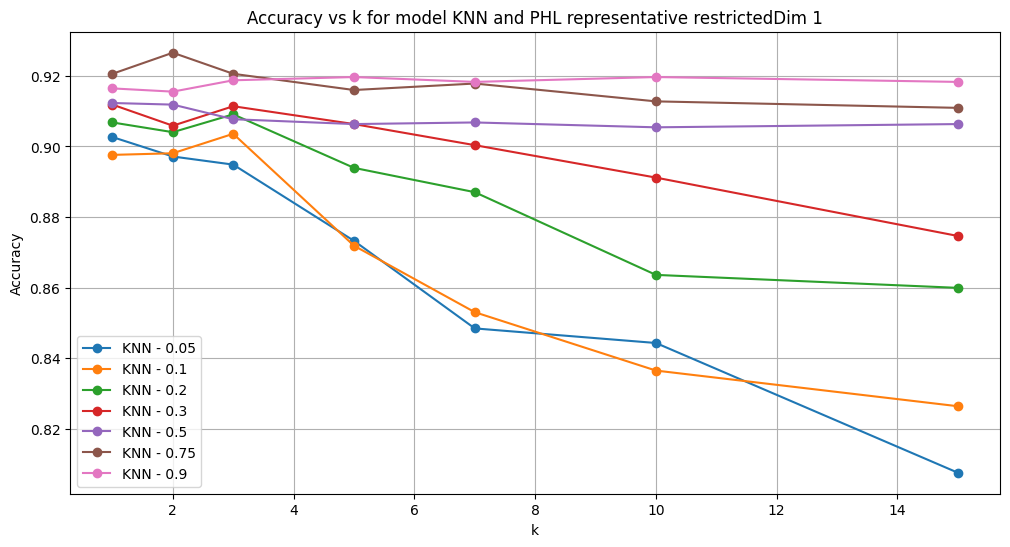

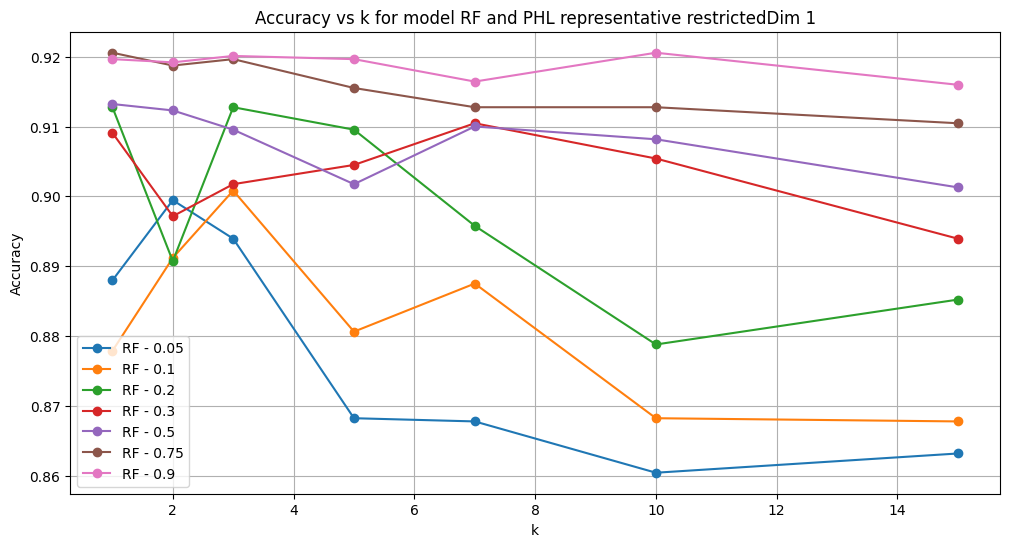

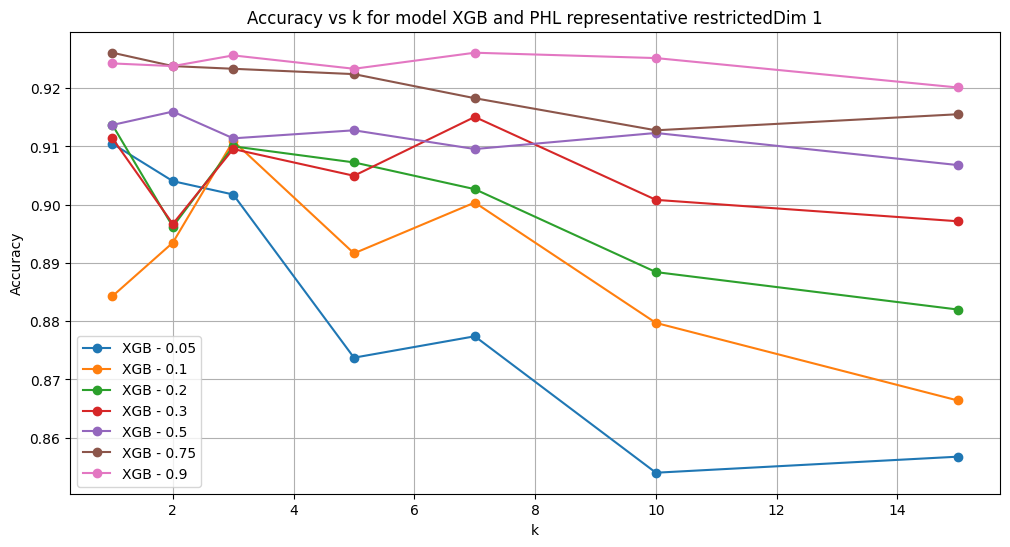

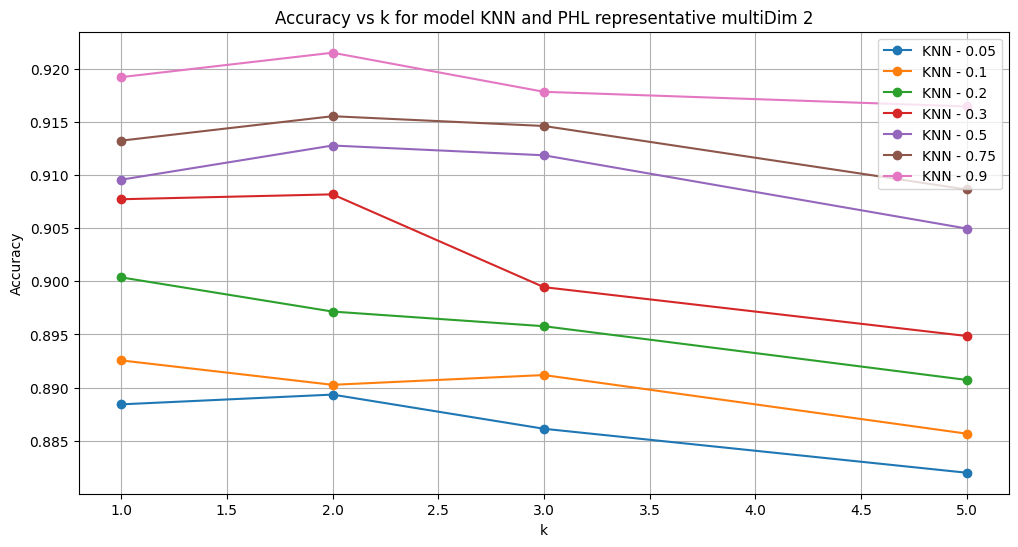

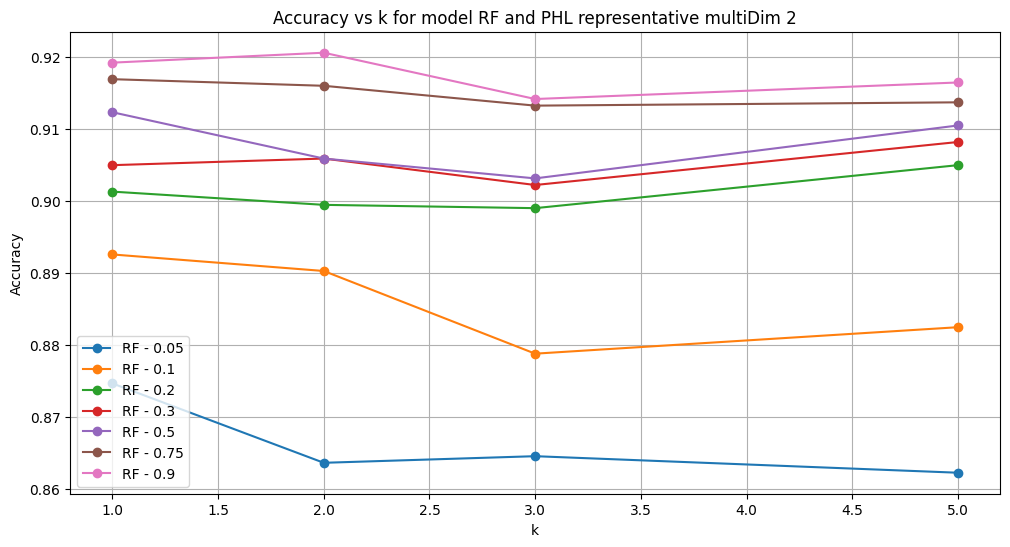

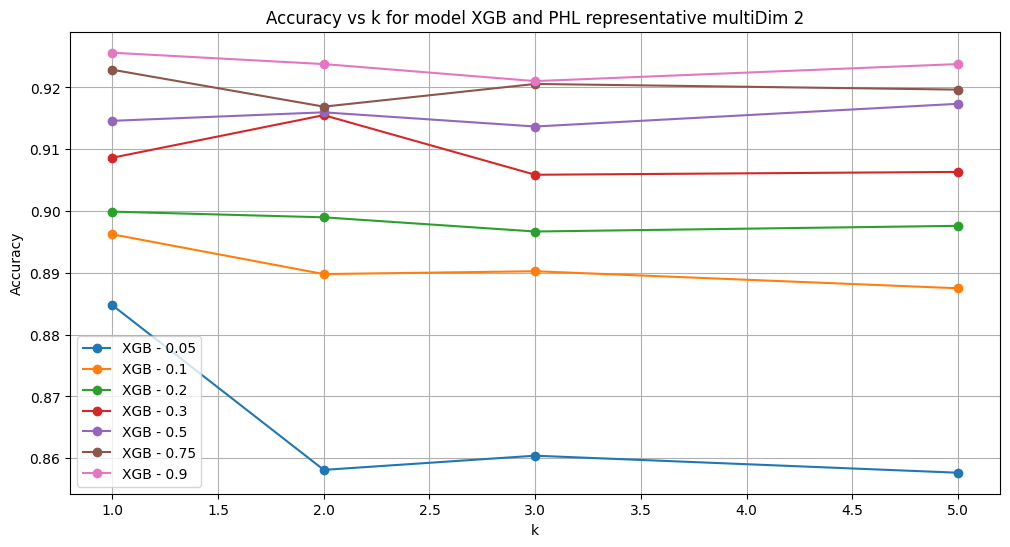

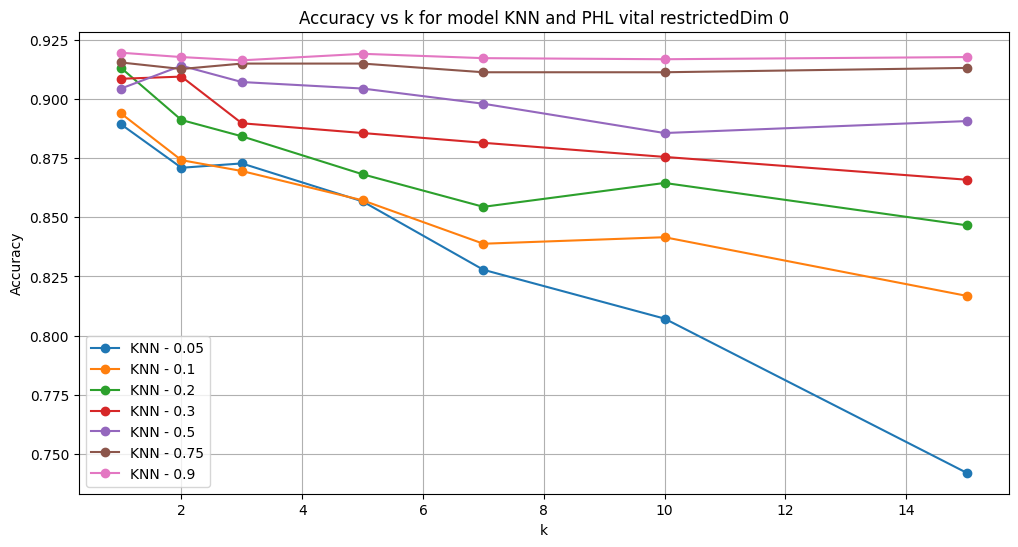

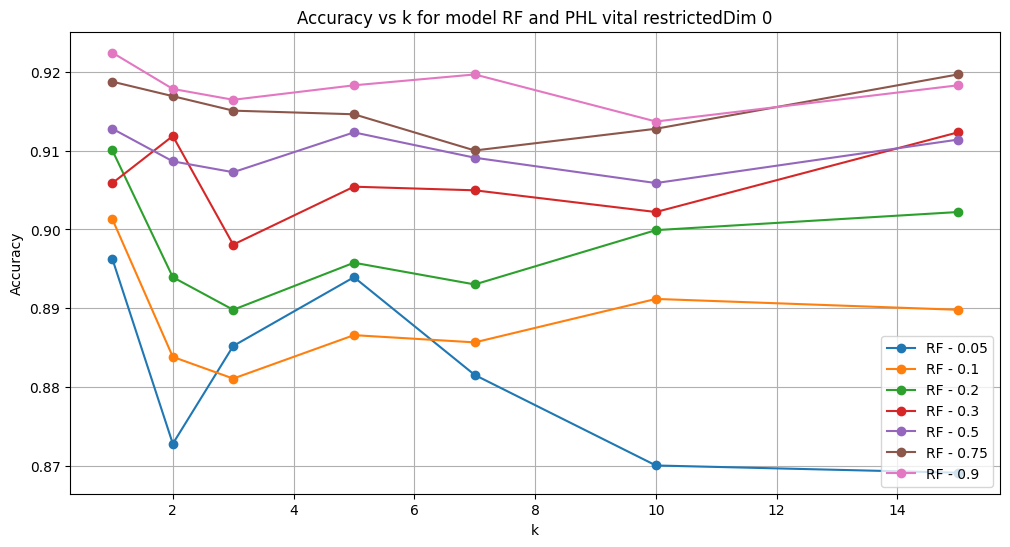

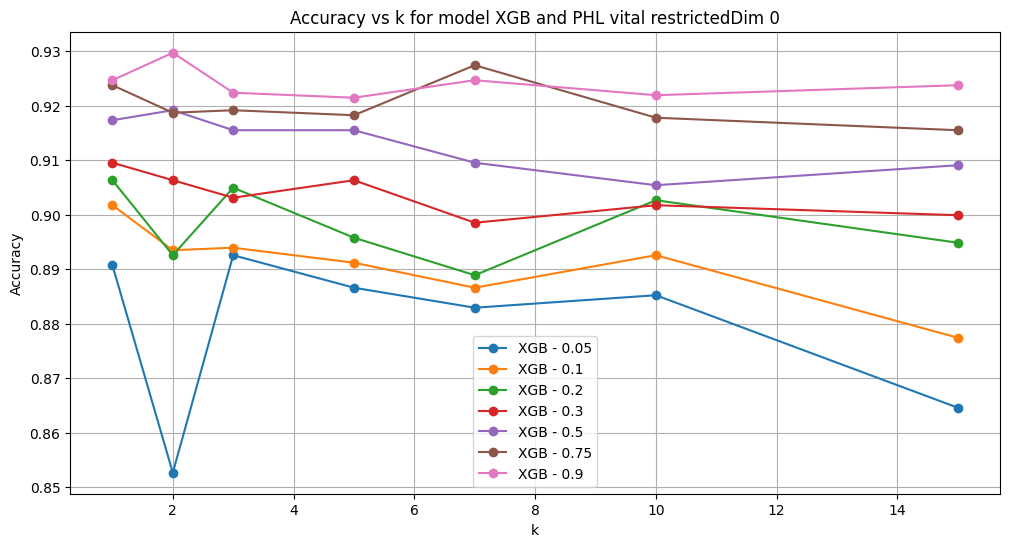

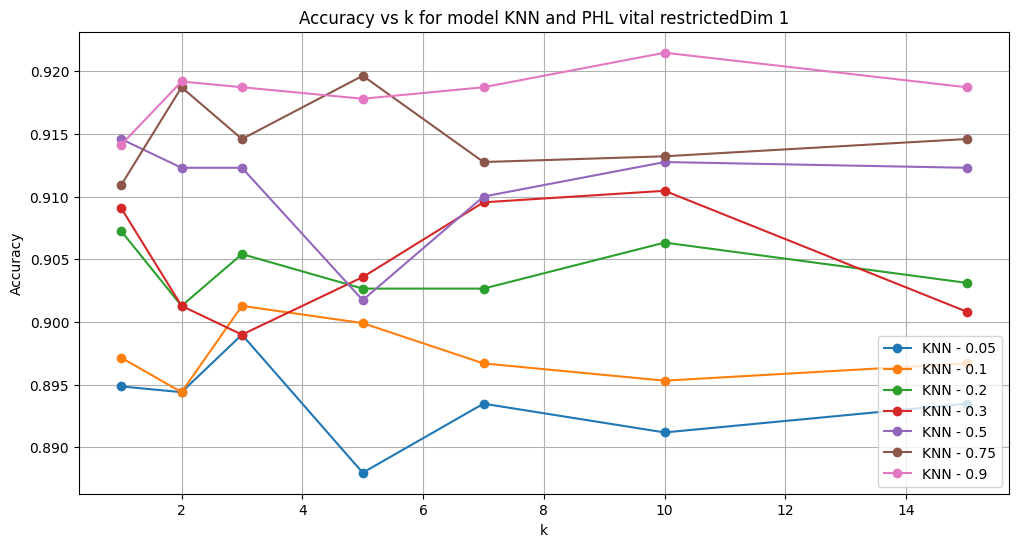

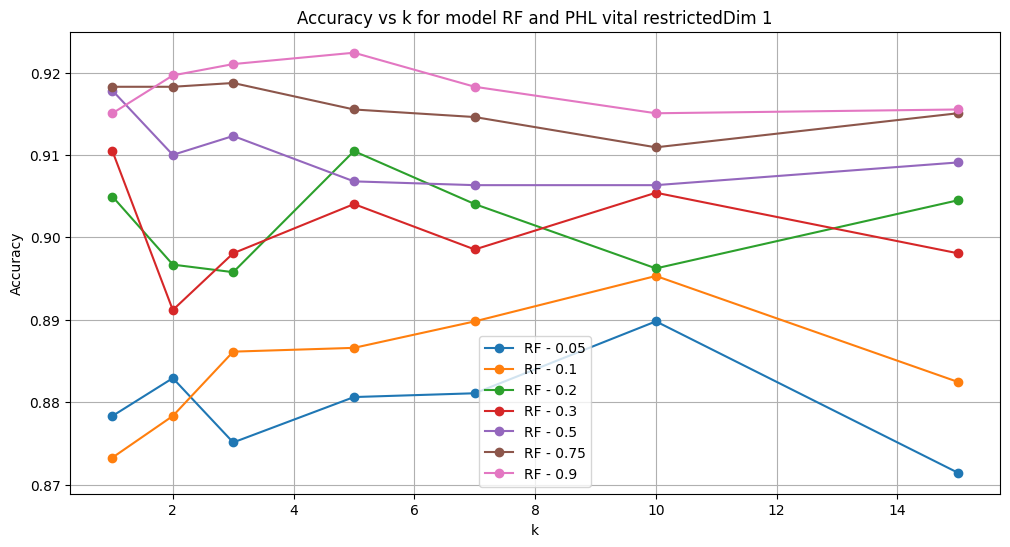

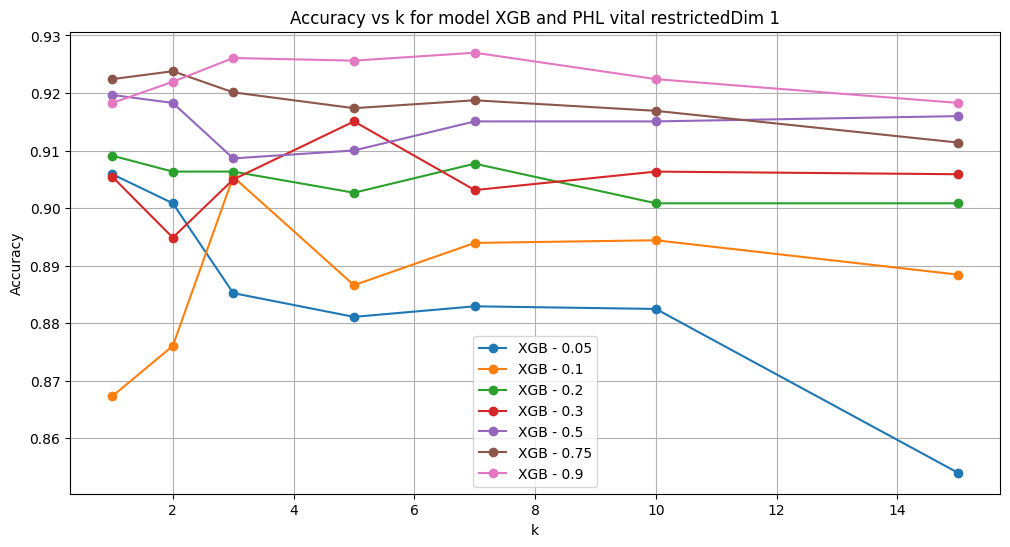

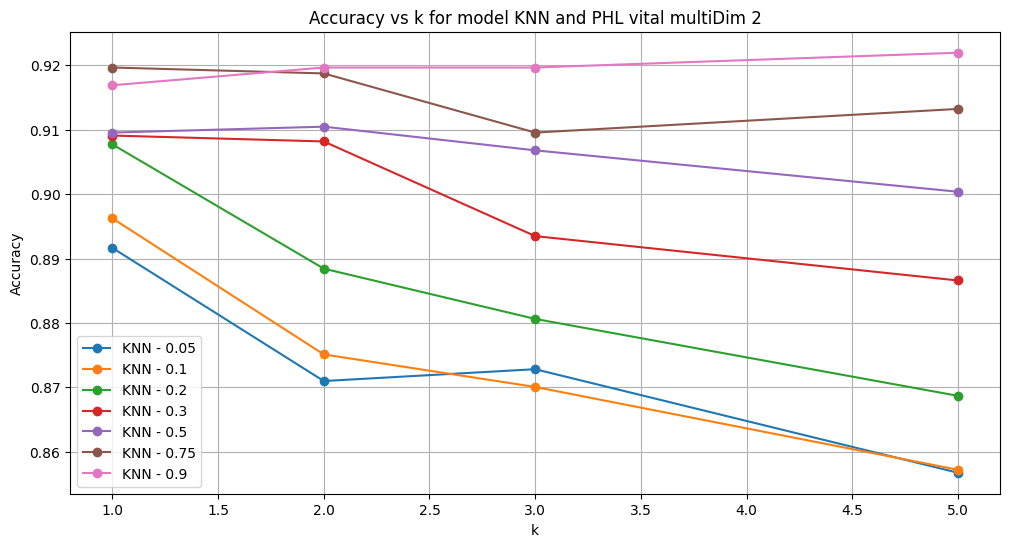

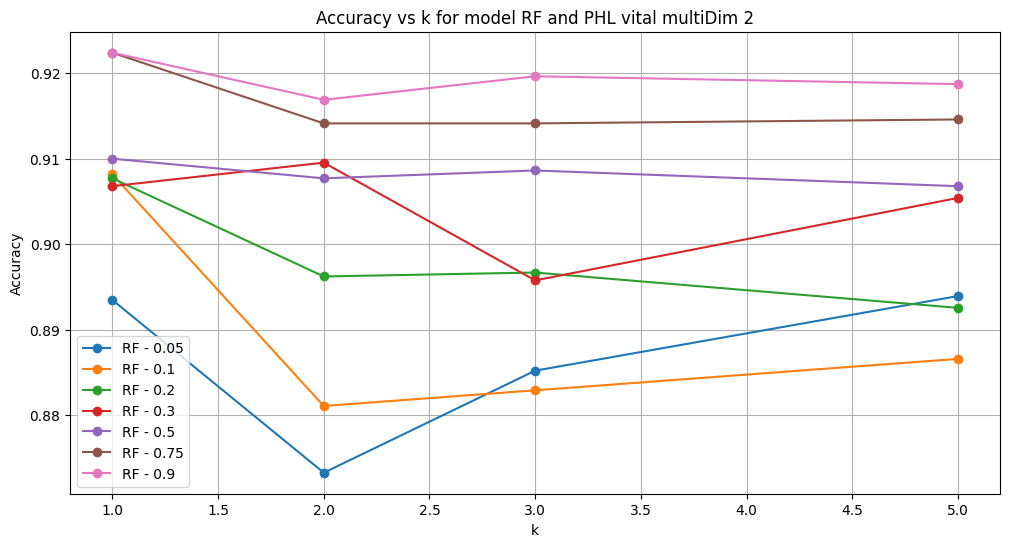

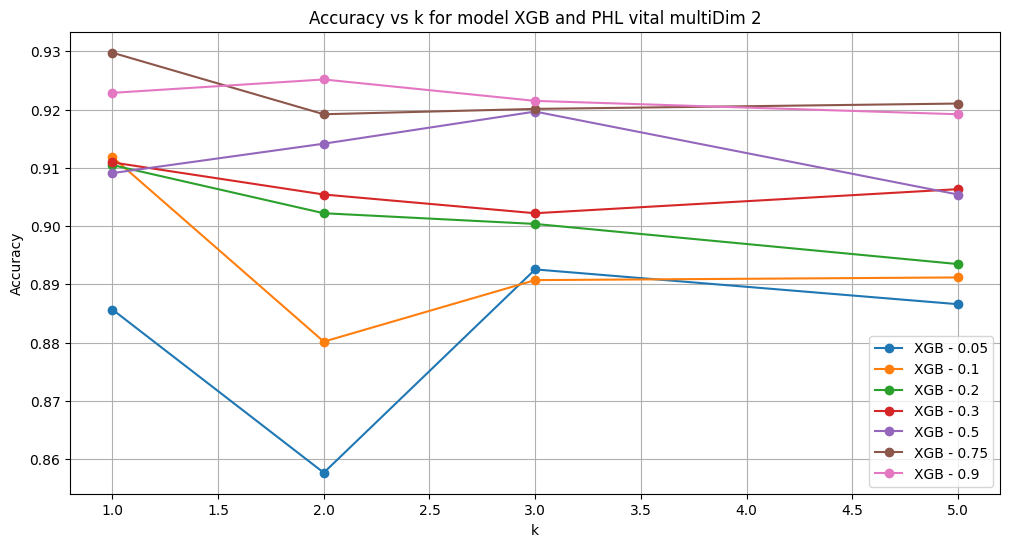

In [138]:
# Show accuracy vs delta for each model
for mode in phl_results['mode'].unique():
    for (scoring_version, dimension) in phl_results[['dimensions', 'max_dimension']].drop_duplicates().values:
        for model_name in phl_results['model'].unique():
            plt.figure(figsize=(12, 6))
            for percentage in phl_results['percentage'].unique():
                plt.plot(phl_results[(phl_results['model'] == model_name) & 
                                     (phl_results['mode'] == mode) & 
                                     (phl_results['dimensions'] == scoring_version) & 
                                     (phl_results['max_dimension'] == dimension) & 
                                     (phl_results['percentage'] == percentage)]
                                     ['k'],
                            phl_results[(phl_results['model'] == model_name) & 
                                    (phl_results['percentage'] == percentage) &
                                    (phl_results['mode'] == mode) & 
                                    (phl_results['dimensions'] == scoring_version) & 
                                    (phl_results['max_dimension'] == dimension)]
                                    ['accuracy'],
                        label=f'{model_name} - {percentage}', marker='o')
                plt.title(f'Accuracy vs k for model {model_name} and PHL {mode} {scoring_version} {dimension}')
                plt.xlabel('k')
                plt.ylabel('Accuracy')
                plt.legend()
                plt.grid()
            # plt.savefig(f'{results_folder}/accuracy_vs_k_{model_name}_{mode}_{scoring_version}_{dimension}.png')
            plt.show()

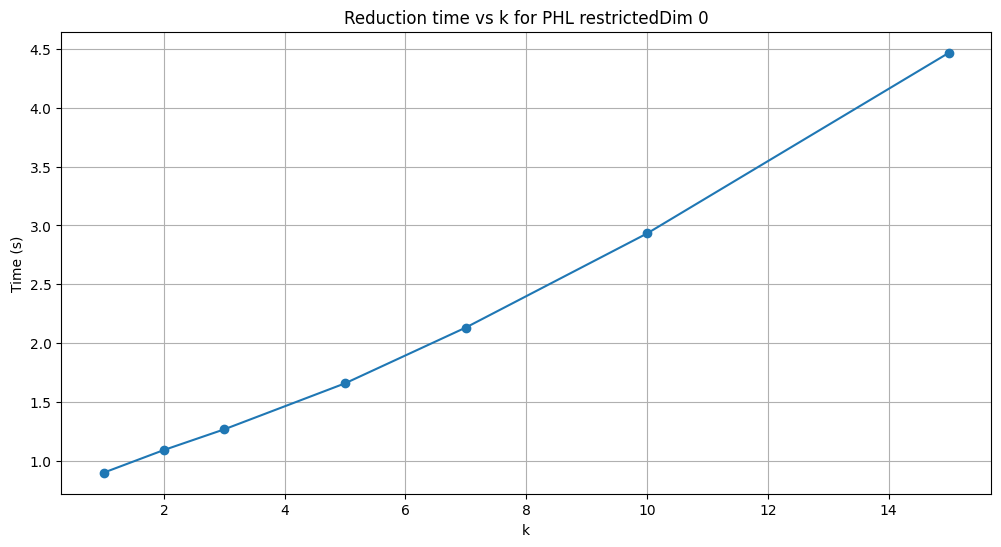

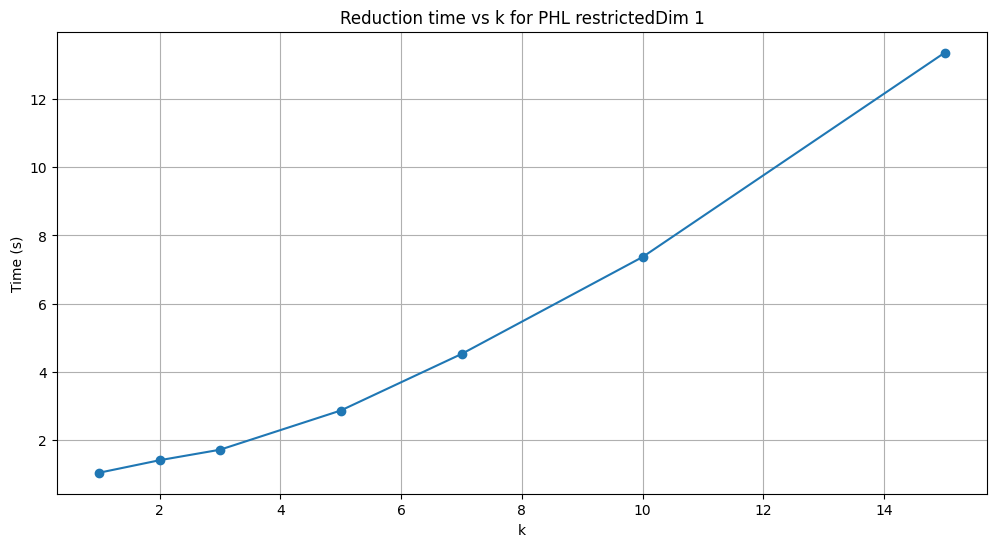

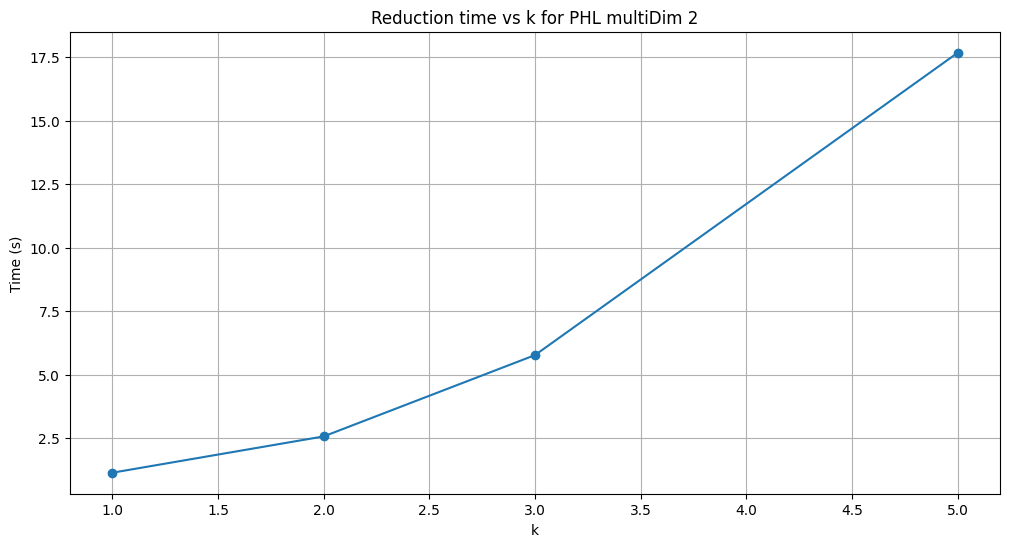

In [139]:
for dimension, scoring_version in phl_results[['max_dimension', 'dimensions']].drop_duplicates().values:
        # Get reduction time vs k averaged by model
        mean_reduction_time_phl = (
            phl_results[
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension)
            ]
            .groupby(['k'])['reduction_time']
            .mean()
            .reset_index()
        )

        # Show time vs k
        plt.figure(figsize=(12, 6))
        plt.plot(
            mean_reduction_time_phl['k'],
            mean_reduction_time_phl['reduction_time'], marker='o'
        )
        plt.title(f'Reduction time vs k for PHL {scoring_version} {dimension}')
        plt.xlabel('k')
        plt.ylabel('Time (s)')
        # plt.yscale('log')
        plt.grid()
        # plt.savefig(f'{results_folder}/reduction_time_vs_k_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

        df_mean_reduction_time = pd.concat([
            df_mean_reduction_time,
            mean_reduction_time_phl.assign(
                scoring_version=scoring_version,
                max_dimension=dimension
            )
        ], ignore_index=True)

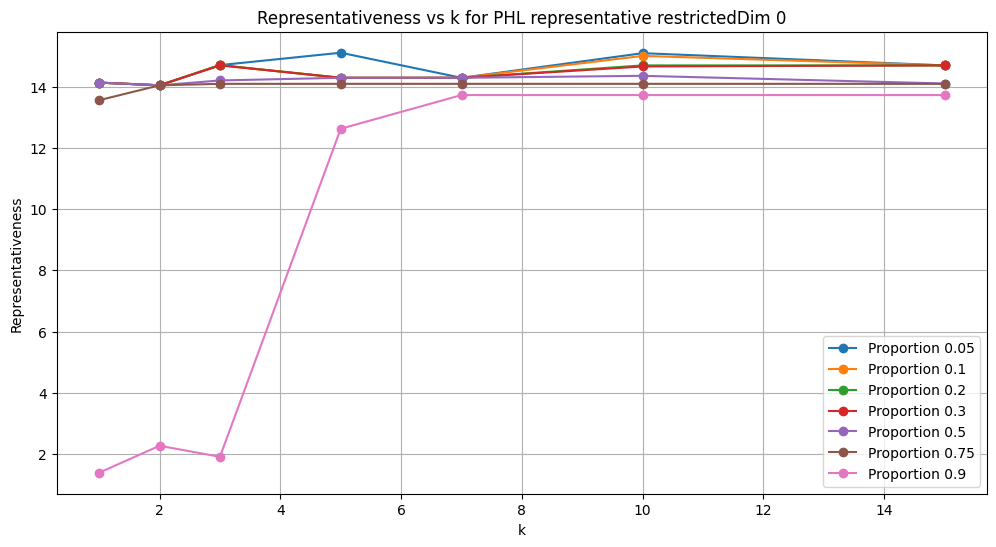

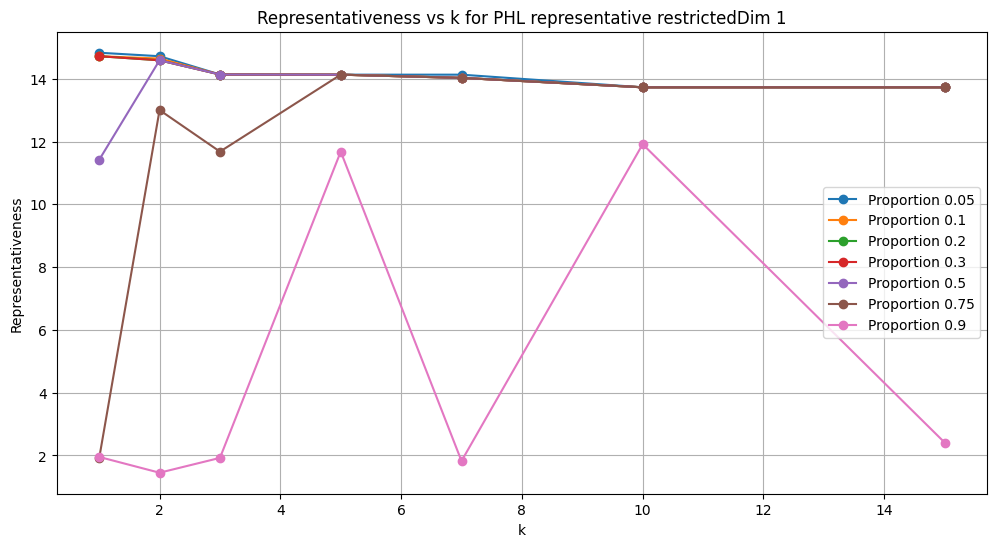

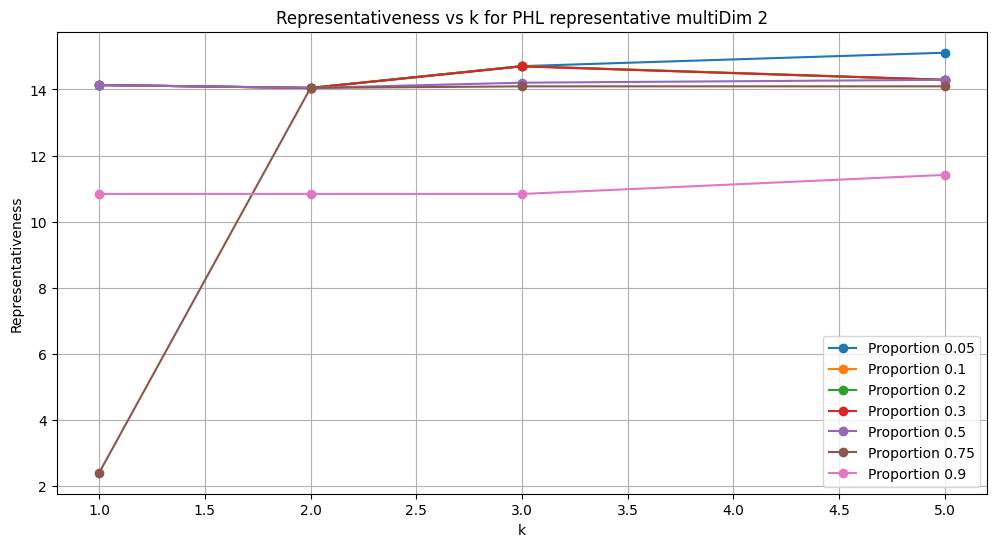

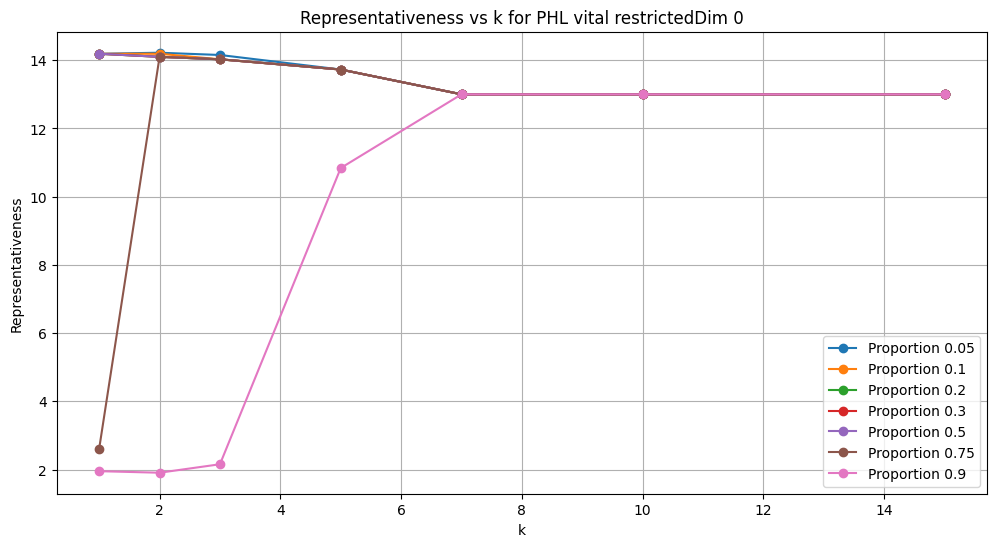

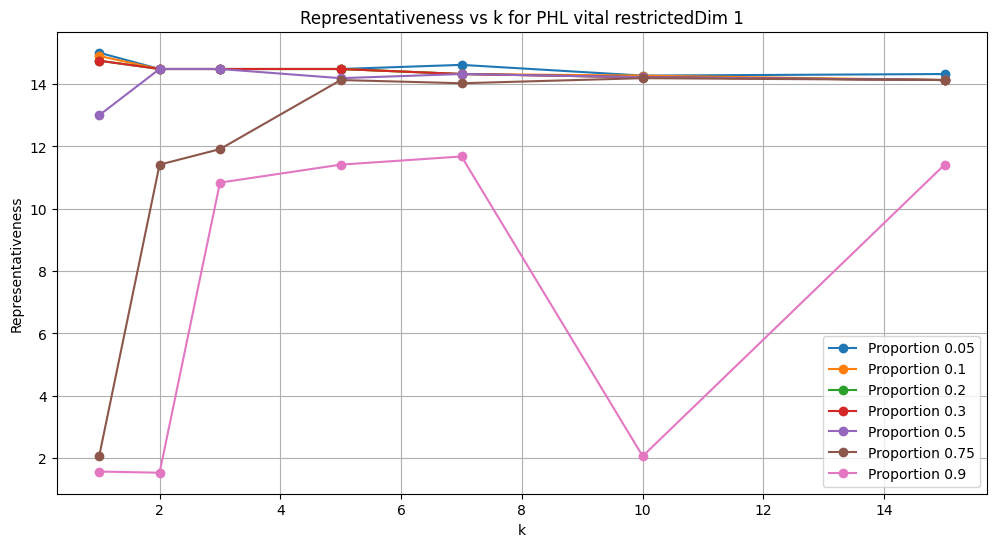

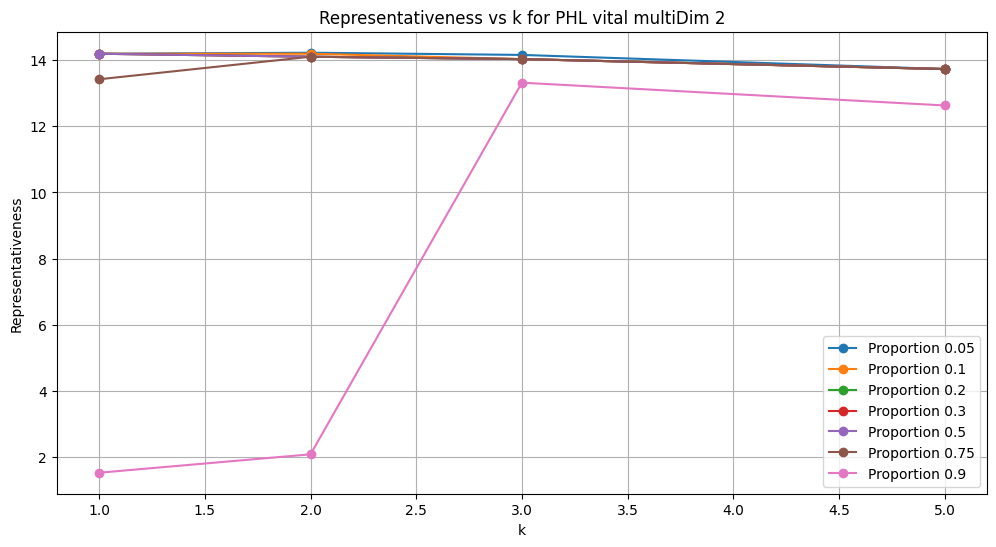

In [140]:
df_mean_reduction_time = pd.DataFrame(columns=['scoring_version', 'max_dimension', 'k', 'reduction_time'])
for mode in phl_results['mode'].unique():
    for dimension, scoring_version in phl_results[['max_dimension', 'dimensions']].drop_duplicates().values:
        # Get representativeness vs k averaged by model
        mean_representativeness_phl = (
            phl_results[
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['reduction_method'] == 'PHL')
            ]
            .groupby(['k', 'percentage'])['representativeness']
            .mean()
            .reset_index()
        )

        # Show representativeness vs k for each percentage
        plt.figure(figsize=(12, 6))
        for percentage in phl_results['percentage'].unique():
            plt.plot(
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['k'],
                mean_representativeness_phl[mean_representativeness_phl['percentage'] == percentage]['representativeness'],
                label=f'Proportion {percentage}', marker='o'
            )
        plt.title(f'Representativeness vs k for PHL {mode} {scoring_version} {dimension}')
        plt.xlabel('k')
        plt.ylabel('Representativeness')
        plt.legend()
        plt.grid()
        # plt.savefig(f'{results_folder}/representativeness_vs_k_{mode}_{scoring_version}_{dimension}.png')
        plt.show()

In [141]:
df_mean_reduction_time

,scoring_version,max_dimension,k,reduction_time


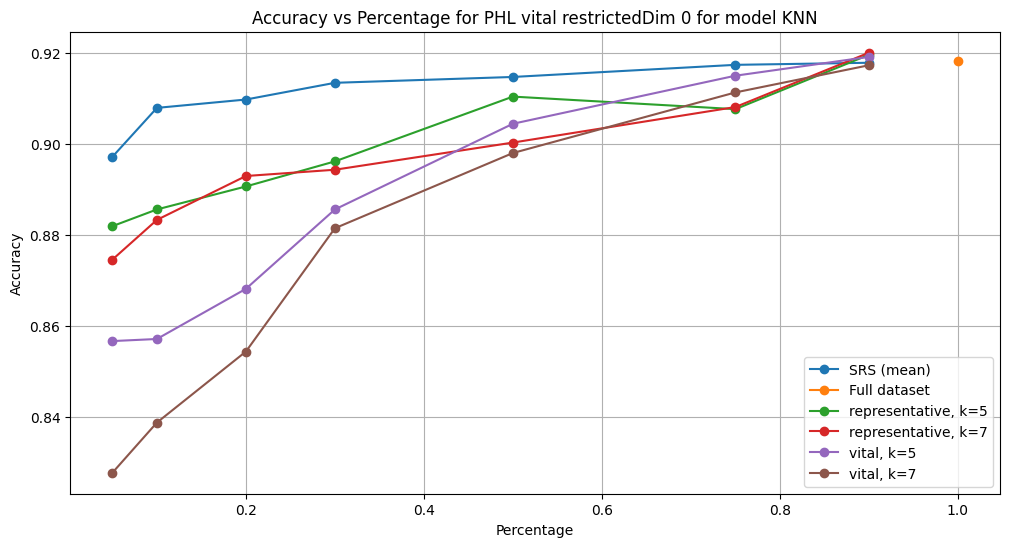

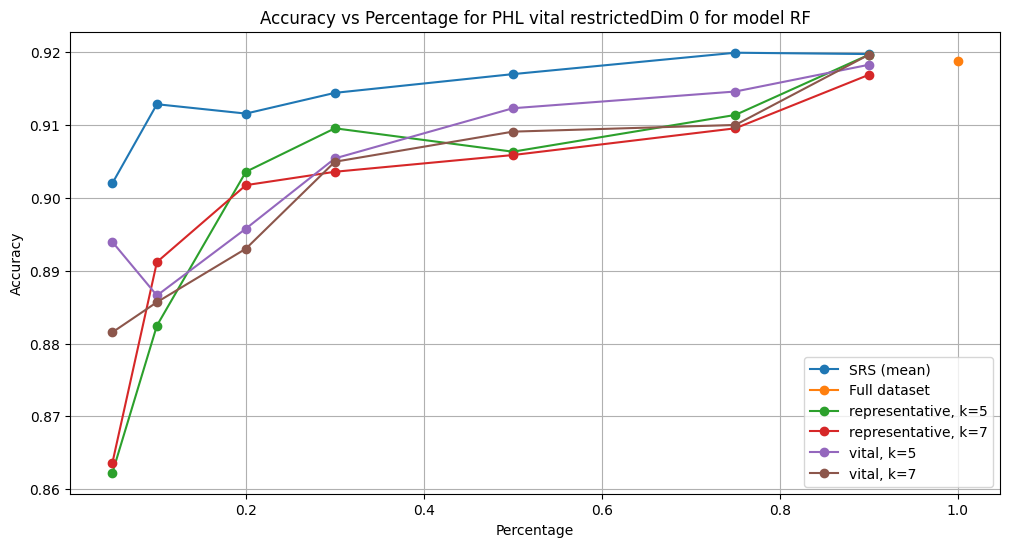

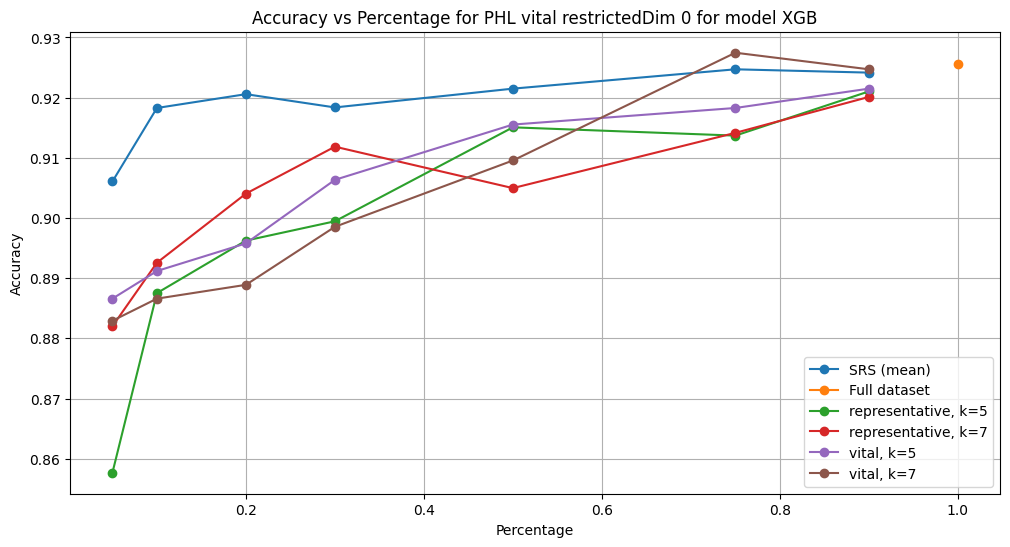

In [157]:
# Plot accuracy vs percentage for selected k, representative and vital modes
scoring_version = 'restrictedDim'
dimension = 0
selected_ks = [5, 7]
for model_name in phl_results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(srs_results[srs_results['model'] == model_name]['percentage'],
             srs_results[srs_results['model'] == model_name]['accuracy'],
             label=f'SRS (mean)', marker='o')
    plt.plot([1.0],
             baseline_results[baseline_results['model'] == model_name]['accuracy'],
             label=f'Full dataset', marker='o')
    for mode in phl_results['mode'].unique():
        for k in selected_ks:
            plt.plot(
                phl_results[
                    (phl_results['model'] == model_name) &
                    (phl_results['mode'] == mode) &
                    (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['k'] == k)
            ]['percentage'],
            phl_results[
                (phl_results['model'] == model_name) &
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['k'] == k)
            ]['accuracy'],
            label=f"{mode}, k={k}", marker='o'
        )
    plt.title(f'Accuracy vs Percentage for PHL {mode} {scoring_version} {dimension} for model {model_name}')
    plt.xlabel('Percentage')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{mode}_{scoring_version}_{dimension}.png')
    plt.show()

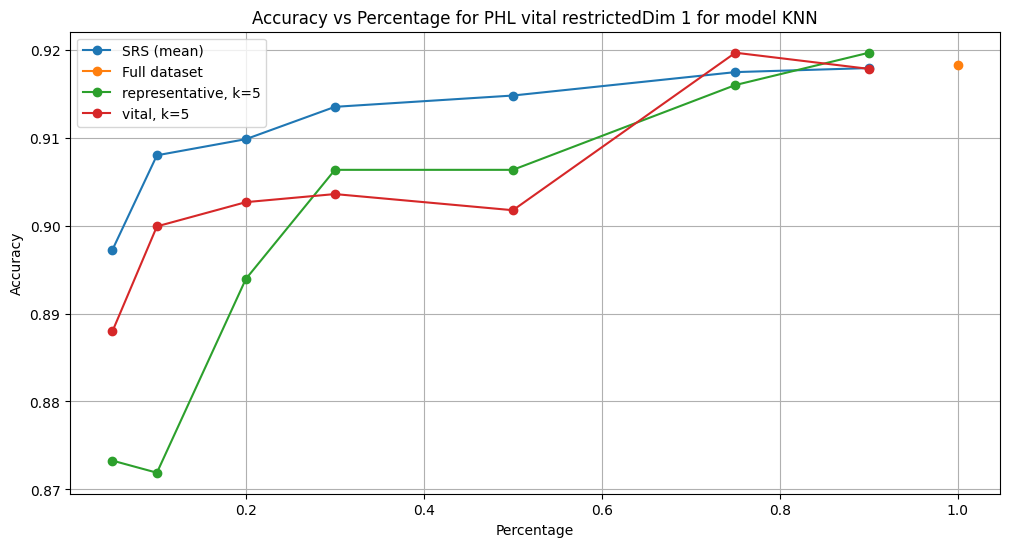

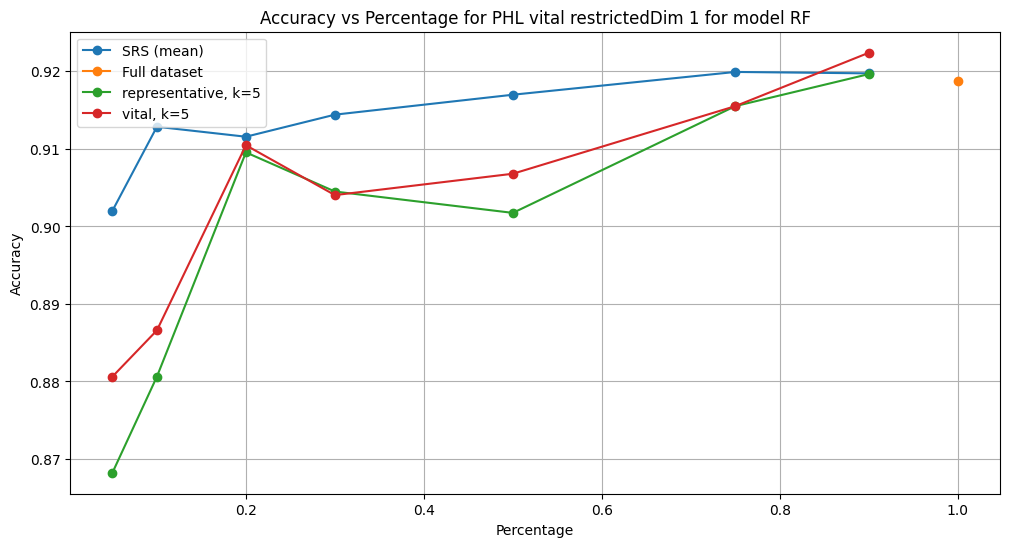

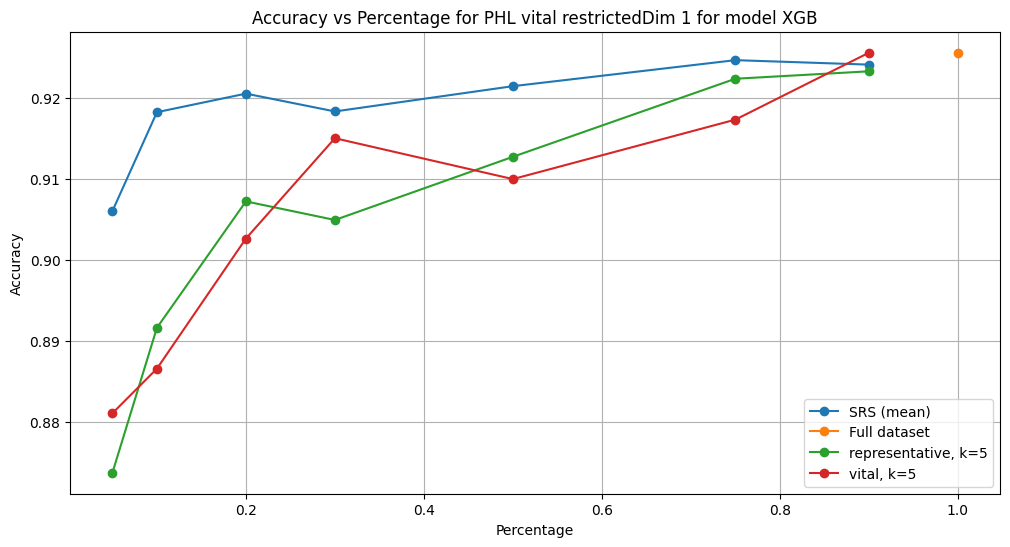

In [156]:
# Plot accuracy vs percentage for selected k, representative and vital modes
scoring_version = 'restrictedDim'
dimension = 1
selected_ks = [5]
for model_name in phl_results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(srs_results[srs_results['model'] == model_name]['percentage'],
             srs_results[srs_results['model'] == model_name]['accuracy'],
             label=f'SRS (mean)', marker='o')
    plt.plot([1.0],
             baseline_results[baseline_results['model'] == model_name]['accuracy'],
             label=f'Full dataset', marker='o')
    for mode in phl_results['mode'].unique():
        for k in selected_ks:
            plt.plot(
                phl_results[
                    (phl_results['model'] == model_name) &
                    (phl_results['mode'] == mode) &
                    (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['k'] == k)
            ]['percentage'],
            phl_results[
                (phl_results['model'] == model_name) &
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['k'] == k)
            ]['accuracy'],
            label=f"{mode}, k={k}", marker='o'
        )
    plt.title(f'Accuracy vs Percentage for PHL {mode} {scoring_version} {dimension} for model {model_name}')
    plt.xlabel('Percentage')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{mode}_{scoring_version}_{dimension}.png')
    plt.show()

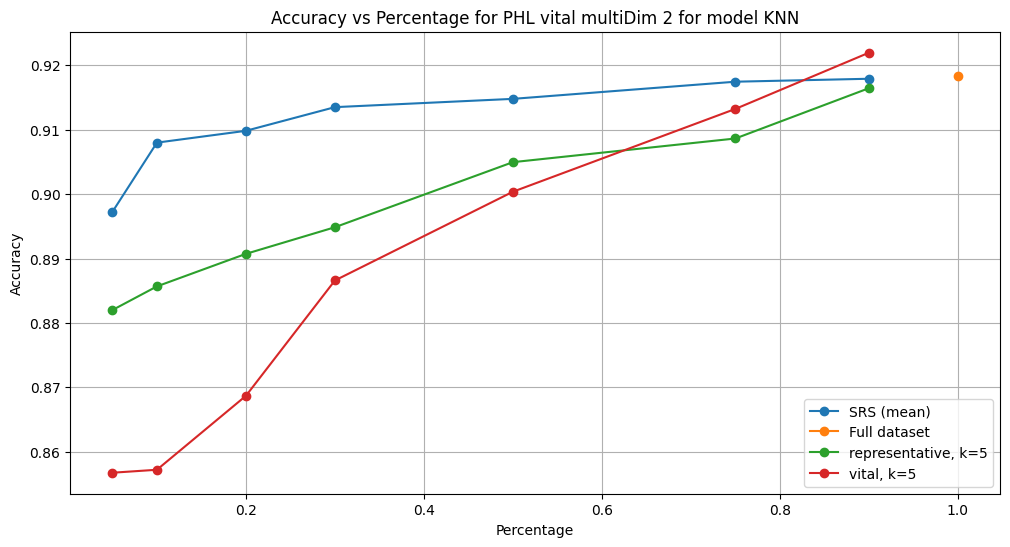

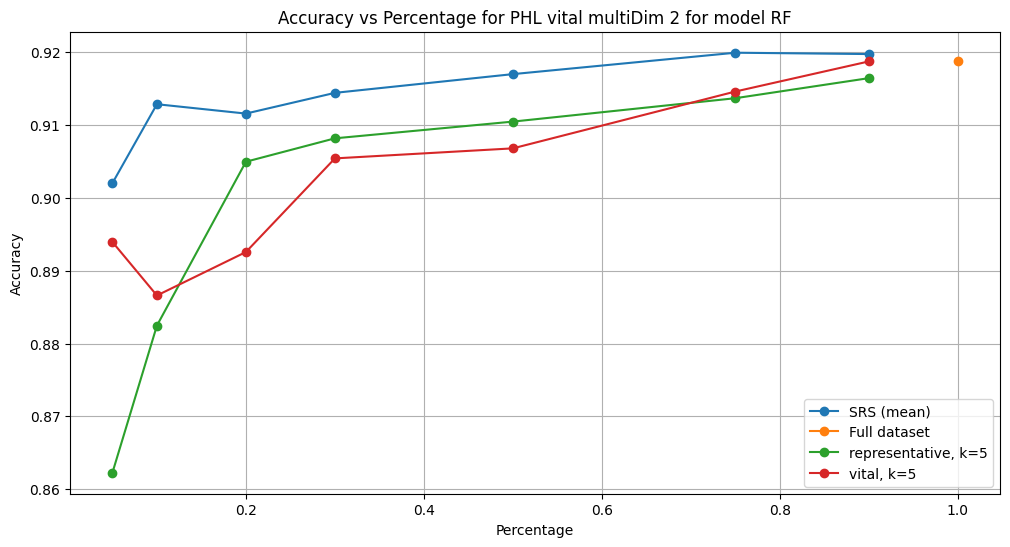

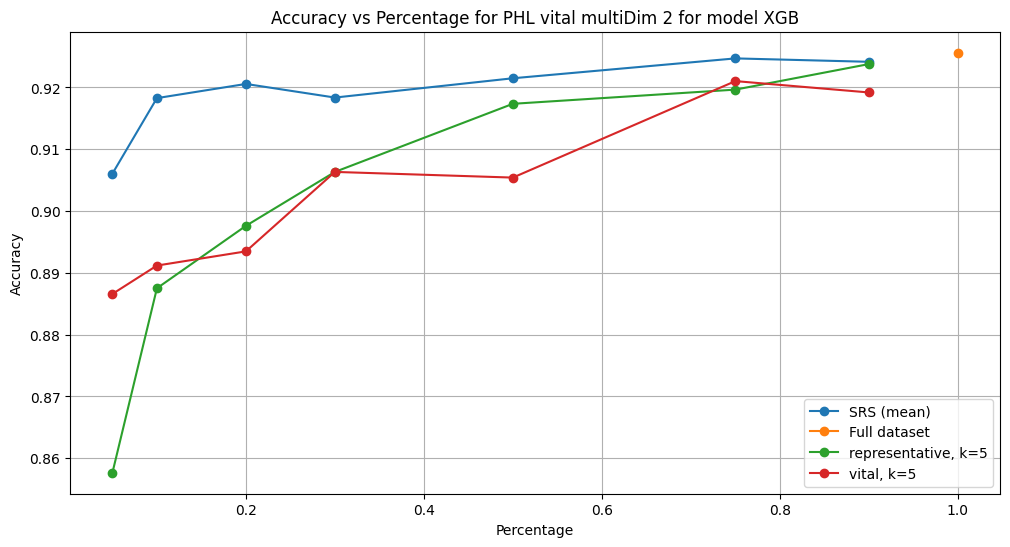

In [158]:
# Plot accuracy vs percentage for selected k, representative and vital modes
scoring_version = 'multiDim'
dimension = 2
selected_ks = [5]
for model_name in phl_results['model'].unique():
    plt.figure(figsize=(12, 6))
    plt.plot(srs_results[srs_results['model'] == model_name]['percentage'],
             srs_results[srs_results['model'] == model_name]['accuracy'],
             label=f'SRS (mean)', marker='o')
    plt.plot([1.0],
             baseline_results[baseline_results['model'] == model_name]['accuracy'],
             label=f'Full dataset', marker='o')
    for mode in phl_results['mode'].unique():
        for k in selected_ks:
            plt.plot(
                phl_results[
                    (phl_results['model'] == model_name) &
                    (phl_results['mode'] == mode) &
                    (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['k'] == k)
            ]['percentage'],
            phl_results[
                (phl_results['model'] == model_name) &
                (phl_results['mode'] == mode) &
                (phl_results['dimensions'] == scoring_version) &
                (phl_results['max_dimension'] == dimension) &
                (phl_results['k'] == k)
            ]['accuracy'],
            label=f"{mode}, k={k}", marker='o'
        )
    plt.title(f'Accuracy vs Percentage for PHL {mode} {scoring_version} {dimension} for model {model_name}')
    plt.xlabel('Percentage')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    # plt.savefig(f'{results_folder}/accuracy_vs_percentage_{mode}_{scoring_version}_{dimension}.png')
    plt.show()

In [ ]:
selected = {'KNN': {0: ('representative', 5), 1: ('vital', 5)},
           'RF': {0: ('vital', 5), 1: ('representative', 5)},
           'XGB': {0: ('vital', 5), 1: ('representative', 5)}}

# Mejor k: 5
# No superan SRS salvo para porcentaje alto porque eliminan outliers